# German Breast Cancer Data

## All packages, hyperparameter evaluation functions

In [1]:
import os
from os import listdir
from os.path import isfile, join
from collections import Counter
import time
from scipy.stats import randint, uniform
from sklearn.utils.fixes import loguniform

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import missingno as msno
import pandas_profiling
from sklearn.metrics import roc_auc_score
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from hyperopt.pyll.base import scope
import pyspark

import xgboost
import shap
import numpy as np
import pandas as pd
from random import sample 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pylab as pl

# Hyperparameters tuning

from hyperopt import STATUS_OK, fmin, hp, tpe, SparkTrials

# Some constants

SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(int(labels[i])) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

#-----------------------XGBoost--------------------------#

def score_xgb(params):
    print("Training with params: ")
    print(params)
    
    n_folds = 5
    val_scores = []
    skf = KFold(n_splits = n_folds, shuffle = False)
    num_boost_round=1000
    #k-fold CV
    for train_index, val_index in skf.split(X_train): 
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        dtrain = xgboost.DMatrix(X_tr, label=y_tr)
        dval = xgboost.DMatrix(X_val, label=y_val)

        watchlist = [(dval, 'eval'), (dtrain, 'train')]
        gbm_model = xgboost.train(params, dtrain, num_boost_round,
                              evals=watchlist,
                              verbose_eval=250)
        
        predictions = gbm_model.predict(dval,
                                    ntree_limit=gbm_model.best_iteration + 1)
        val_scores.append(c_statistic_harrell(predictions, list(y_val)))
    
    score = np.mean(val_scores) #Objective: maximize mean 5-fold CV C-index 
    
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize_xgb(score, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # XGB param ranges obtained from Barnwal A, Cho H, Hocking T (2020). Survival regression with accelerated failure time model in XGBoost: 
    # https://arxiv.org/pdf/2006.04920.pdf
    # exception: min_child_weight, reg_alpha and reg_lambda capped at 10 rather than 100
    space = {
        'eta':                         hp.loguniform('eta', np.log(0.001), np.log(1)),
        'max_depth':                   scope.int(hp.quniform('max_depth', 2,10,1)),
        'min_child_weight':            hp.loguniform('min_child_weight', np.log(0.001), np.log(10)),
        'reg_alpha':                   hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
        'reg_lambda':                  hp.loguniform('reg_lambda', np.log(0.001), np.log(10)),
        'subsample':                   hp.uniform('subsample', 0.75, 1),
        "objective": "survival:cox"
    }
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                max_evals=100)
    return best

## Set Directory to Save Files (Assumed that Files needed for reading are in current working directory)

In [2]:
# Set working directory to save all figures (create directory beforehand)
save_to = save_to = os.getcwd() + '/'

# Breast Cancer

## Prep Datasets 

### Normalized Data

In [4]:
All_bcd = pd.read_csv("XGB_BCDS_normalized.csv")
X_bcd_id = All_bcd['id']
X_bcd = All_bcd.drop(columns = ['id','survtime','censdead','SURV_DAY_XGB'])
y_bcd = All_bcd['SURV_DAY_XGB']
y_bcd.head()

0   -2282
1   -2006
2    1456
3    -148
4   -1863
Name: SURV_DAY_XGB, dtype: int64

In [5]:
print(X_bcd.shape)
X_bcd.head()

(686, 8)


,age,menopause,hormone,size,grade,nodes,prog_recp,estrg_recp
0,0.288136,0,0,0.128205,3,5,0.059244,0.091783
1,0.525424,0,0,0.145299,1,1,0.032773,0.012238
2,0.440678,0,0,0.230769,2,1,0.177311,0.077797
3,0.322034,0,0,0.179487,1,3,0.010504,0.009615
4,0.728814,1,1,0.136752,2,1,0.007983,0.007867


In [6]:
print(y_bcd.shape)
y_bcd.head()

(686,)


0   -2282
1   -2006
2    1456
3    -148
4   -1863
Name: SURV_DAY_XGB, dtype: int64

## Hyperparameter tuning, 100 evaluation rounds to find best hyperparameters to run our XGB Model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_bcd, y_bcd, test_size=0.2, random_state=20)

In [9]:
print("---- Running XGBoost ----")
start=time.time()
xgb_best_hyperparams = optimize_xgb(score_xgb)
end=time.time()
print("Done: took", (end-start)/60, "minutes")
print("---- Results for XGBoost ----")
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams)

---- Running XGBoost ----
Training with params:                                  
{'eta': 0.578826344617033, 'max_depth': 5, 'min_child_weight': 0.005213123272652775, 'objective': 'survival:cox', 'reg_alpha': 0.2792524457272663, 'reg_lambda': 0.03244599053133823, 'subsample': 0.8435049296826771}
[0]	eval-cox-nloglik:12.71057	train-cox-nloglik:5.59205

[250]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[500]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[0]	eval-cox-nloglik:11.13401	train-cox-nloglik:5.69107

[250]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[500]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[0]	eval-cox-nloglik:3.98827	train-cox-nloglik:6.54573 

[250]	eval-cox-nloglik:nan	train-cox-nloglik:nan       

[500]	eval-cox-nlog

In [10]:
xgb_best_hyperparams['max_depth']=round(xgb_best_hyperparams['max_depth'])
xgb_best_hyperparams['objective']="survival:cox"
print(xgb_best_hyperparams)

{'eta': 0.0020570934235303907, 'max_depth': 2, 'min_child_weight': 1.0366918633482902, 'reg_alpha': 0.09867275783575628, 'reg_lambda': 0.018996023853840978, 'subsample': 0.7939301950114278, 'objective': 'survival:cox'}


In [7]:
xgb_best_hyperparams = {'eta': 0.002329846232948934, 'max_depth': 2, 'min_child_weight': 0.0017462626013389445, 'reg_alpha': 0.07220221910190468, 'reg_lambda': 1.6058311333673232, 'subsample': 0.7582893091214069, 'objective': 'survival:cox'}

## KFold CV 

In [12]:
xgb_scores =[]

n_folds = 5
num_boost_round=1000
skf = KFold(n_splits=n_folds)
c = 1
#k-fold CV 
for train_index, val_index in skf.split(X_train): 
    print ("Round", c, "Start")
    start = time.time()
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        
    dtrain = xgboost.DMatrix(X_tr, label=y_tr)
    dval = xgboost.DMatrix(X_val, label=y_val)

    watchlist = [(dval, 'eval'), (dtrain, 'train')]
    xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                          evals=watchlist,
                          verbose_eval=250)

    predictions = xgb_model.predict(dval,
                                ntree_limit=xgb_model.best_iteration + 1)
    xgb_scores.append(c_statistic_harrell(predictions, list(y_val)))
    print("XGB Done")
    end=time.time()
    print("Round", c, "Done:", (end-start)/60, "minutes")
    c += 1

Round 1 Start
[0]	eval-cox-nloglik:4.12657	train-cox-nloglik:5.55922
[250]	eval-cox-nloglik:3.85962	train-cox-nloglik:5.28377
[500]	eval-cox-nloglik:3.76334	train-cox-nloglik:5.16440
[750]	eval-cox-nloglik:3.72765	train-cox-nloglik:5.08977
[999]	eval-cox-nloglik:3.70900	train-cox-nloglik:5.03299
XGB Done
Round 1 Done: 0.02184113661448161 minutes
Round 2 Start
[0]	eval-cox-nloglik:4.26564	train-cox-nloglik:5.51851
[250]	eval-cox-nloglik:4.10865	train-cox-nloglik:5.19495
[500]	eval-cox-nloglik:4.10332	train-cox-nloglik:5.06193
[750]	eval-cox-nloglik:4.12105	train-cox-nloglik:4.98221
[999]	eval-cox-nloglik:4.14724	train-cox-nloglik:4.92680
XGB Done
Round 2 Done: 0.019694801171620688 minutes
Round 3 Start
[0]	eval-cox-nloglik:4.09051	train-cox-nloglik:5.56152
[250]	eval-cox-nloglik:3.90447	train-cox-nloglik:5.29184
[500]	eval-cox-nloglik:3.82392	train-cox-nloglik:5.17513
[750]	eval-cox-nloglik:3.78274	train-cox-nloglik:5.10356
[999]	eval-cox-nloglik:3.76112	train-cox-nloglik:5.05316
XGB Do

In [13]:
xgb_scores

[0.7839305103148752,
 0.6783340717766947,
 0.7650669642857143,
 0.7093124456048738,
 0.8002033553634977]

In [14]:
num_boost_round=1000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dval, 'eval'), (dtrain, 'train')]
xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                      evals=watchlist,
                      verbose_eval=250)

predictions = xgb_model.predict(dval,
                            ntree_limit=xgb_model.best_iteration + 1)

xgb_test_score = c_statistic_harrell(predictions, list(y_test))
print("XGB Done:", xgb_test_score)

[0]	eval-cox-nloglik:4.46372	train-cox-nloglik:5.76823
[250]	eval-cox-nloglik:4.21004	train-cox-nloglik:5.49720
[500]	eval-cox-nloglik:4.14188	train-cox-nloglik:5.38288
[750]	eval-cox-nloglik:4.12351	train-cox-nloglik:5.31458
[999]	eval-cox-nloglik:4.13030	train-cox-nloglik:5.26651
XGB Done: 0.7380418535127056


# XGB Cox Bootstrap SHAP Vals 

## All covs feature set up

In [8]:
params = {'eta': 0.002329846232948934,
          'max_depth': 2, 
          'min_child_weight': 0.0017462626013389445, 
          'reg_alpha': 0.07220221910190468, 
          'reg_lambda': 1.6058311333673232, 
          'subsample': 0.7582893091214069, 
          'objective': 'survival:cox'}

full_xy = X_bcd.copy()
y_labels = y_bcd.copy()
full_xy['y'] = y_labels
X_features = X_bcd.columns

HazardRatioAge = [] 
idx_age=X_features.get_loc('age')

HazardRatioMenopause = [] 
idx_menopause=X_features.get_loc('menopause')

HazardRatioHormone = [] 
idx_hormone=X_features.get_loc('hormone')

HazardRatioSize = [] 
idx_size=X_features.get_loc('size')

HazardRatioGrade = [] 
idx_grade=X_features.get_loc('grade')

HazardRatioNodes = [] 
idx_nodes=X_features.get_loc('nodes')

HazardRatioProgRecp = [] 
idx_progrecp=X_features.get_loc('prog_recp')

HazardRatioEstrgRecp = []
idx_estrgrecp=X_features.get_loc('estrg_recp')

In [16]:
X_bcd.age.median()

0.5423728813559322

In [17]:
X_bcd.menopause.unique()

array([0, 1])

In [18]:
X_bcd['size'].unique()

array([0.12820513, 0.14529915, 0.23076923, 0.17948718, 0.13675214,
       0.45299145, 0.41880342, 0.16239316, 0.18803419, 0.31623932,
       0.1025641 , 0.27350427, 0.4017094 , 0.15384615, 0.05982906,
       0.35897436, 0.11965812, 0.07692308, 0.17094017, 0.48717949,
       0.34188034, 0.22222222, 0.26495726, 0.04273504, 0.06837607,
       0.2991453 , 0.21367521, 0.82905983, 0.44444444, 0.11111111,
       0.28205128, 0.20512821, 0.24786325, 0.65811966, 0.4957265 ,
       0.23931624, 0.52991453, 0.33333333, 0.08547009, 0.1965812 ,
       0.25641026, 0.39316239, 0.29059829, 0.46153846, 0.30769231,
       0.05128205, 0.09401709, 0.61538462, 0.03418803, 0.57264957,
       0.47008547, 0.38461538, 1.        , 0.01709402, 0.        ,
       0.35042735, 0.64102564, 0.00854701])

In [19]:
X_bcd.grade.unique()

array([3, 1, 2])

In [20]:
X_bcd['size'].median()

0.18803418803418806

In [21]:
X_bcd.prog_recp.median()

0.01365546218487395

In [22]:
X_bcd.estrg_recp.median()

0.03146853146853147

In [23]:
full_xy

,age,menopause,hormone,size,grade,nodes,prog_recp,estrg_recp,y
0,0.288136,0,0,0.128205,3,5,0.059244,0.091783,-2282
1,0.525424,0,0,0.145299,1,1,0.032773,0.012238,-2006
2,0.440678,0,0,0.230769,2,1,0.177311,0.077797,1456
3,0.322034,0,0,0.179487,1,3,0.010504,0.009615,-148
4,0.728814,1,1,0.136752,2,1,0.007983,0.007867,-1863
...,...,...,...,...,...,...,...,...,...
681,0.508475,0,0,0.401709,2,5,0.151261,0.049825,-17
682,0.711864,1,1,0.162393,2,9,0.026891,0.016608,-857
683,0.677966,1,0,0.487179,2,51,0.018908,0.033217,-768
684,0.423729,0,0,0.196581,1,3,0.013866,0.059441,-858


In [9]:
full_xy = X_bcd.copy()
y_labels = y_bcd.copy()
full_xy['y'] = y_labels
X_features = X_bcd.columns
myHazRatios = [[] for i in range(len(X_bcd.columns))]
myIndexes = [i for i in range(len(X_bcd.columns))]
# print(myHazRatios_all, myIndexes_all)
myBinCols = [col for col in X_bcd.columns if all(X_bcd[col].value_counts().index.isin([0, 1]))]
myContCols = [col for col in X_bcd.columns if not all(X_bcd[col].value_counts().index.isin([0, 1]))]

print("My list of binary columns are :\n", myBinCols)

print("\nMy list of cont. columns are :\n", myContCols)

My list of binary columns are :
 ['menopause', 'hormone']

My list of cont. columns are :
 ['age', 'size', 'grade', 'nodes', 'prog_recp', 'estrg_recp']


In [25]:
full_xy.head()

,age,menopause,hormone,size,grade,nodes,prog_recp,estrg_recp,y
0,0.288136,0,0,0.128205,3,5,0.059244,0.091783,-2282
1,0.525424,0,0,0.145299,1,1,0.032773,0.012238,-2006
2,0.440678,0,0,0.230769,2,1,0.177311,0.077797,1456
3,0.322034,0,0,0.179487,1,3,0.010504,0.009615,-148
4,0.728814,1,1,0.136752,2,1,0.007983,0.007867,-1863


In [11]:
#bootstrap!
for i in range(1, 1001):
#   sample with replacement:
    X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
    y_train = X_train['y'] #y train are X_trains y column
    X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
    X_test = full_xy.drop(X_train.index) #test features are the full - X_train
    y_test = X_test['y'] #y test are X_tests y column
    X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
    xgb_train = xgboost.DMatrix(X_train, label=y_train)
    xgb_test = xgboost.DMatrix(X_test, label=y_test)
    model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
    shap_values_full = shap.TreeExplainer(model_train).shap_values(X_bcd)
    
#   let's build a list of HazRatios indexing by j columns
    for j in range(len(myIndexes)):
        curSHAP = shap_values_full[:, j]
        curCol = X_bcd.columns[j]
        # if continuous, split by median
        if (curCol in myContCols):
            myMed = X_bcd[curCol].median()
            myHazRatios[j].append(np.mean(np.exp(curSHAP[X_bcd[curCol] >= myMed]))
                                  /np.mean(np.exp(curSHAP[X_bcd[curCol] < myMed])))
        # else, split by 1 or 0
        else:
            myHazRatios[j].append(np.mean(np.exp(curSHAP[X_bcd[curCol] == 1]))
                                  /np.mean(np.exp(curSHAP[X_bcd[curCol] == 0])))

  
#Done!

In [18]:
# myHazRatios 
# indexed by column index
X_features = X_bcd.columns
# create a list of lists of length 4: [[Median, Mean, LB, UB], [...]]
mySummaries = []
for i in range(len(myHazRatios)):
    myHazRatios[i].sort()
    mySummaries.append([np.median(myHazRatios[i]), 
                                  myHazRatios[i][24], myHazRatios[i][974]])

# print([i for i in range(len(myHazRatios_all)) if X_features[i] in myContinuousCols])
print(mySummaries)

[[1.0755843, 0.94723684, 1.2668722], [1.0, 0.99099153, 1.0089844], [0.9562363, 0.7792321, 1.0], [1.1982852, 1.0276458, 1.5030464], [1.0220244, 1.0, 1.223608], [1.8678429, 1.4421599, 2.5125444], [0.38551936, 0.27466166, 0.53775483], [0.9298928, 0.736622, 1.0447654]]


## Get all binary cols

In [19]:
COX_bins_all = pd.read_csv("summary_coxPH_BINARYVARS_bcd.csv")
# get only HR, LB, and UB
COX_bins_all = COX_bins_all[["Covariate", "HR", "LB", "UB"]]
# COX_bins.Covariate
list_HRs_all = [[COX_bins_all['HR'][i], COX_bins_all['LB'][i], COX_bins_all['UB'][i]] for i in range(len(COX_bins_all['Covariate']))]
df_cox_bins_all = pd.DataFrame(list_HRs_all, 
                           columns = ["medianHR", "LB_HR", "UB_HR"], 
                           index = COX_bins_all['Covariate'])

# errors_bin_cox_all = np.array([list(df_cox_bins_all.medianHR - df_cox_bins_all.LB_HR),list(df_cox_bins_all.UB_HR - df_cox_bins_all.medianHR)])

COX_conts_all = pd.read_csv("summary_coxPH_nonbinVARS.csv")
myList_all = list(COX_conts_all.iloc[0])
HRs_cont_all = []
# print(int(len(myList) / 3))
for i in range(int(len(myList_all)/3)):
    HRs_cont_all.append([myList_all[(3*i)], 
                     myList_all[(3*i) + 1], 
                     myList_all[(3*i) + 2]])
    
df_cox_conts_all = pd.DataFrame(HRs_cont_all, index = ["age", "size", "grade", "nodes", "prog_recp","estrg_recp"], columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
# errorsContCOXAll = np.array([list(df_cox_conts_all.medianHR - df_cox_conts_all.LB_HR),list(df_cox_conts_all.UB_HR - df_cox_conts_all.medianHR)])


In [20]:
print(df_cox_bins_all.head())
print(df_cox_conts_all.head())

           medianHR     LB_HR     UB_HR
Covariate                              
menopause  1.105178  0.673560  1.813377
hormone    0.767082  0.551216  1.067484
           medianHR     LB_HR     UB_HR
age        1.118705  0.751723  1.664844
size       1.284994  1.074148  1.537227
grade      1.718134  1.196677  2.466817
nodes      1.404701  1.245998  1.583618
prog_recp  0.342240  0.214867  0.545121


In [21]:
origCols = list(X_features)
origCols = origCols[:1] + origCols[3:8] + origCols[1:3]
origCols

['age',
 'size',
 'grade',
 'nodes',
 'prog_recp',
 'estrg_recp',
 'menopause',
 'hormone']

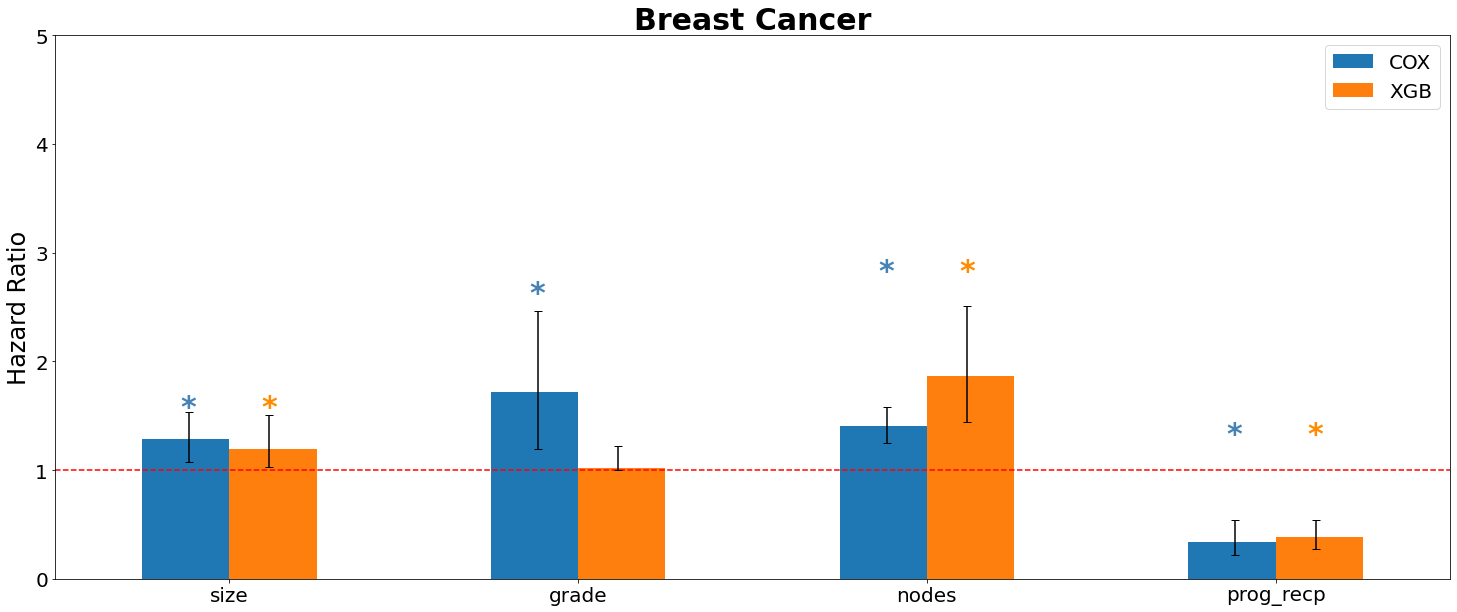

In [27]:
#append lists
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 10]
errorsDictSig = {}
totalCoxList =  HRs_cont_all + list_HRs_all  
mySummaries_reor = mySummaries[:1] + mySummaries[3:8] + mySummaries[1:3] 
#get the union of all sig covs
all_sig_covs = [origCols[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]

# all_sig_covs_names = [tup[0] for tup in all_sig_covs]
# all_sig_covs_numInd = [tup[1] for tup in all_sig_covs]
xgb_sig_covs = [mySummaries_reor[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]

cox_sig_covs = [totalCoxList[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]


#rename (if needed)


df_cox_sig_all = pd.DataFrame(cox_sig_covs, index = all_sig_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errorsCoxSig = np.array([list(df_cox_sig_all.medianHR - df_cox_sig_all.LB_HR),list(df_cox_sig_all.UB_HR - df_cox_sig_all.medianHR)])
errorsDictSig["COX"] = errorsCoxSig

df_xgb_sig_all = pd.DataFrame(xgb_sig_covs, index = all_sig_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
errorsXGBSig = np.array([list(df_xgb_sig_all.medianHR - df_xgb_sig_all.LB_HR),list(df_xgb_sig_all.UB_HR - df_xgb_sig_all.medianHR)])
errorsDictSig["XGB"] = errorsXGBSig

#All Sig Variables
total_plot_sig_all = pd.DataFrame({"COX":list(df_cox_sig_all.medianHR), 
                          "XGB":list(df_xgb_sig_all.medianHR)},
                         index = all_sig_covs)

cats = all_sig_covs
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax_sig = total_plot_sig_all.plot.bar(rot=0)
ax_sig.set_title("Breast Cancer", fontsize = 30, weight = "heavy")
ax_sig.axhline(y=1 , color='r', linestyle='--')
ax_sig.set_ylabel("Hazard Ratio", fontsize = 24)
ax_sig.set_ylim((0, 5))
for label in (ax_sig.get_xticklabels() + ax_sig.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_sig_all.medianHR, yerr = errorsDictSig["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_sig_all.medianHR, yerr = errorsDictSig["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)


plt.text(0-.140, 1.5, "*", fontsize= 30,weight="heavy", color = "SteelBlue")
plt.text(0+.092, 1.5, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
plt.text(1-.140, 2.55, "*", fontsize= 30, weight="heavy", color = "SteelBlue")
plt.text(2-.14, 2.75, "*", fontsize= 30, weight="heavy", color = "SteelBlue")
plt.text(2+.092, 2.75, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
plt.text(3-.14, 1.25, "*", fontsize= 30, weight="heavy", color = "SteelBlue")
plt.text(3+.092, 1.25, "*", fontsize= 30, weight="heavy", color = "DarkOrange")

plt.savefig(save_to + 'bcd_sigonly_allcov_XGB_COX.png',  bbox_inches = "tight", dpi = 400)

In [32]:
df_xgb_sig_all

,medianHR,LB_HR,UB_HR
size,1.156242,1.010027,1.484406
grade,1.006834,0.999434,1.200703
nodes,1.684592,1.203189,2.393775
prog_recp,0.351927,0.231629,0.532820


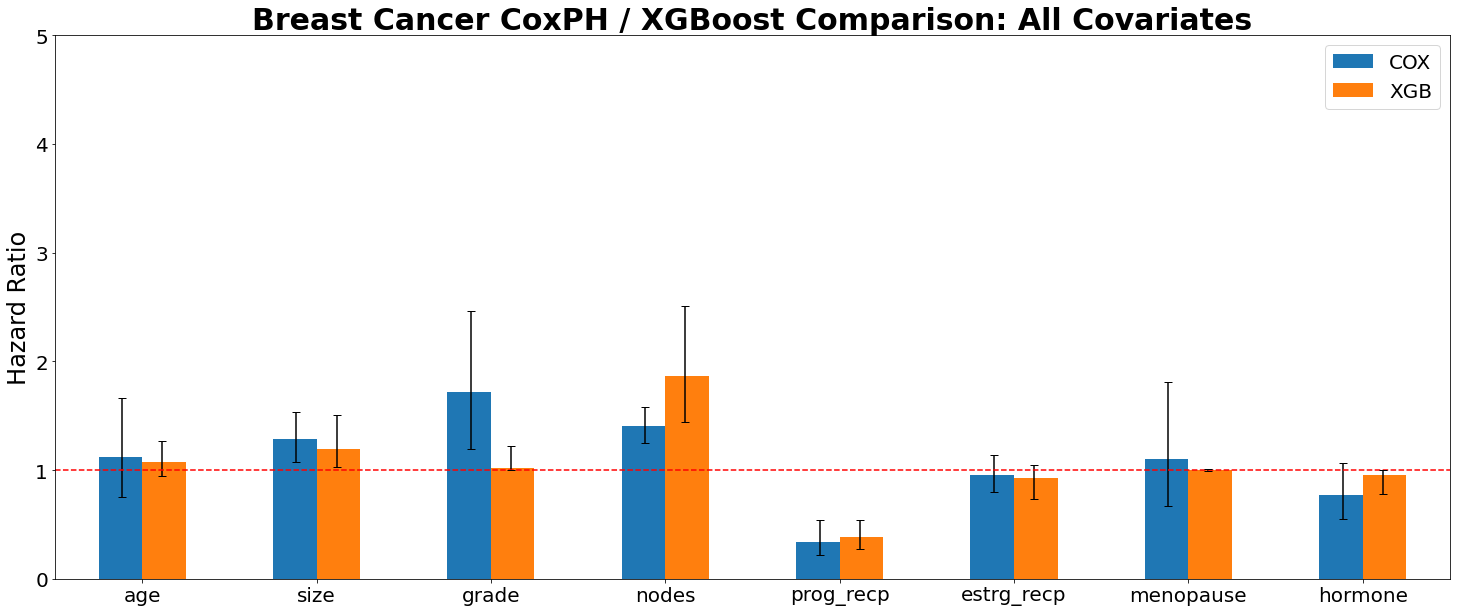

In [30]:
#append lists
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 10]
errorsDictAll = {}
# totalCoxList =  HRs_cont_all + list_HRs_all  
# mySummaries_reor = mySummaries[:1] + mySummaries[2:3] + mySummaries[6:9] + mySummaries[1:2] + mySummaries[3:6] + mySummaries[9:]
#get the union of all sig covs
all_covs = [origCols[i] for i in range(len(origCols))]

# all_sig_covs_names = [tup[0] for tup in all_sig_covs]
# all_sig_covs_numInd = [tup[1] for tup in all_sig_covs]
xgb_all_covs = [mySummaries_reor[i] for i in range(len(origCols))]

cox_all_covs = [totalCoxList[i] for i in range(len(origCols))]

#rename (if needed)


df_cox_all = pd.DataFrame(cox_all_covs, index = all_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errorsCoxAll = np.array([list(df_cox_all.medianHR - df_cox_all.LB_HR),list(df_cox_all.UB_HR - df_cox_all.medianHR)])
errorsDictAll["COX"] = errorsCoxAll

df_xgb_all = pd.DataFrame(xgb_all_covs, index = all_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
errorsXGBSig = np.array([list(df_xgb_all.medianHR - df_xgb_all.LB_HR),list(df_xgb_all.UB_HR - df_xgb_all.medianHR)])
errorsDictAll["XGB"] = errorsXGBSig

#All Sig Variables
total_plot_all = pd.DataFrame({"COX":list(df_cox_all.medianHR), 
                          "XGB":list(df_xgb_all.medianHR)},
                         index = all_covs)

cats = all_covs
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax = total_plot_all.plot.bar(rot=0)
ax.set_title("Breast Cancer CoxPH / XGBoost Comparison: All Covariates", fontsize = 30, weight = "heavy")
ax.axhline(y=1 , color='r', linestyle='--')
ax.set_ylabel("Hazard Ratio", fontsize = 24)
ax.set_ylim((0, 5))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_all.medianHR, yerr = errorsDictAll["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_all.medianHR, yerr = errorsDictAll["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)

# plt.text(0-.15, 1.5, "*", fontsize= 30,weight="heavy", color = "Navy")
# # plt.text(0+.092, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
# plt.text(1+.092, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
# plt.text(2-.15, 2.75, "*", fontsize= 30, weight="heavy", color = "Navy")
# plt.text(2+.092, 2.75, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
# plt.text(3-.15, 2.5, "*", fontsize= 30, weight="heavy", color = "Navy")
# plt.text(3+.092, 2.5, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
# plt.text(4-.15, 2, "*", fontsize= 30, weight="heavy", color = "Navy")
# plt.text(4+.092, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
plt.savefig(save_to + 'bcd_allcov_XGB_COX.png')

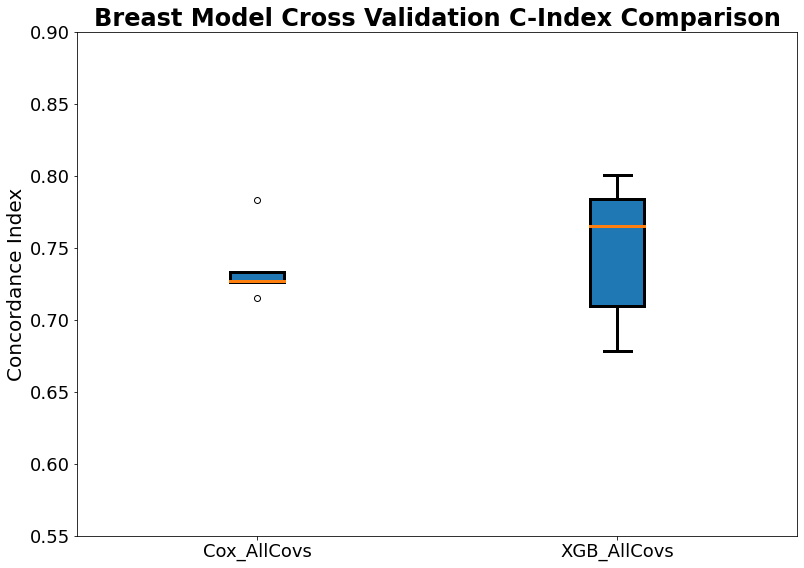

<Figure size 1800x720 with 0 Axes>

In [34]:
coxCs = [0.7331452, 0.715131, 0.7260905, 0.7266426, 0.782861]
xgbCs = [0.7839305103148752,
 0.6783340717766947,
 0.7650669642857143,
 0.7093124456048738,
 0.8002033553634977]


box_data = [coxCs, xgbCs]
# print(box_data)
fig = plt.figure(figsize =(10, 7)) 
  
# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'24', 'color':'black', 'weight':'heavy'} # Bottom vertical alignment for more space
axis_font = {'size':'20'}
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_xticklabels(['Cox_AllCovs', 'XGB_AllCovs'])
ax.set_title("Breast Model Cross Validation C-Index Comparison", **title_font)
ax.set_ylabel("Concordance Index", **axis_font)
ax.set_ylim(0.55, 0.90)



# for item in [ax.title]:
#     item.set_fontsize(20)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(18)

# Creating plot 
bp = ax.boxplot(box_data, patch_artist=True) 

for median in bp['medians']:
    median.set(linewidth=3)

for box in bp['boxes']:
# change outline color
    box.set(linewidth=3)

for whisker in bp['whiskers']:
    whisker.set(linewidth =3)

for cap in bp['caps']:
    cap.set(linewidth=3)

# show plot 
plt.show()
plt.savefig(save_to + 'bcd_box_plot_cindex.png')

# SHAP

In [31]:
#Model trained, using for SHAP analysis
X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
y_train = X_train['y'] #y train are X_trains y column
X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
X_test = full_xy.drop(X_train.index) #test features are the full - X_train
y_test = X_test['y'] #y test are X_tests y column
X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)
model_train_SHAP = xgboost.train(xgb_best_hyperparams, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
shap_values= shap.TreeExplainer(model_train_SHAP).shap_values(X_bcd)
   


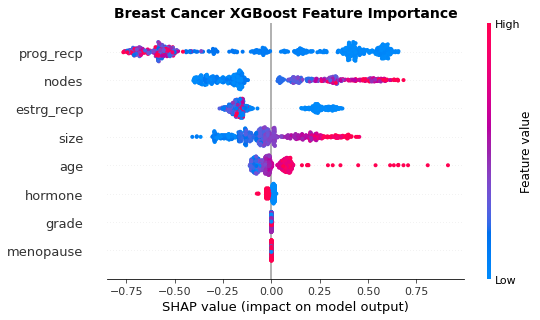

In [32]:
shap.summary_plot(shap_values, X_bcd, show = False)
plt.title("Breast Cancer XGBoost Feature Importance", fontsize = 14, weight = 'bold')
plt.savefig(save_to + "importance_plot_all_XGBoost_BCD.png",  bbox_inches = "tight", dpi = 400) 